In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc as sklearn_auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

-------


### Create combined DF

In [44]:
albums = pd.read_csv('albums_colors_nudity_skin_gender.csv')
features = pd.read_csv('album_features_complete.csv')
artist_info = pd.read_csv('artists_with_info_new.csv')

In [45]:
## Features cleaning ##

# Convert hex color codes to numeric RGB components
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Process each dominant color
for i in range(1, 6):
    hex_col = f'color_{i}_hex'
    r_col = f'color_{i}_R'
    g_col = f'color_{i}_G'
    b_col = f'color_{i}_B'

    # Apply conversion, handle missing or invalid entries
    rgb_data = features[hex_col].fillna('#000000').apply(hex_to_rgb).tolist()
    features[r_col] = [rgb[0] for rgb in rgb_data]
    features[g_col] = [rgb[1] for rgb in rgb_data]
    features[b_col] = [rgb[2] for rgb in rgb_data]

# Drop original hex columns/non-numeric/text/unneeded columns
drop_cols = [f'color_{i}_hex' for i in range(1, 6)] + ['text_content', 'width', 'height','aspect_ratio','image_url']
features = features.drop(columns=drop_cols)

# Convert boolean columns to integers
bool_cols = features.select_dtypes(include='bool').columns
features[bool_cols] = features[bool_cols].astype(int)

In [46]:
#Clean artist_info
artist_info = artist_info.rename(columns={'popularity':'artist_popularity'})
artist_info = artist_info.drop(['genres','artist_name'],axis=1)

#merge to albums df
albums = albums.merge(artist_info, on='artist_id')


In [47]:
df = albums.merge(features, on='album_id')
df = df.drop_duplicates()
df = df.drop(['artist_name','artist_id','genre','album_name','release_date','image_url','album_id'],axis=1)

#albums cleaning
#we have percentage color columns
df = df.drop(['black', 'blue', 'gray','orange','red','white','green','pink','yellow','purple'], axis=1)
#group gender diverse categories
group_map = {'non-binary':'gender_diverse',
    'trans woman': 'gender_diverse',
    'genderfluid':'gender_diverse'}
df['gender'] = df['gender'].replace(group_map)

# One‑hot encode the genres/gender
df = pd.get_dummies(df, columns=['genre_condensed'], prefix='genre')
df = pd.get_dummies(df, columns=['gender'], prefix='gender')

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

#df.to_csv('../data/new/final_modeling_df.csv')

print(df.shape)
df.head()

(3262, 100)


,total_tracks,popularity,face,female_genitalia_covered,buttocks_exposed,female_breast_exposed,female_genitalia_exposed,male_breast_exposed,anus_exposed,feet_exposed,...,genre_rap/hip hop,genre_reggae,genre_relaxed,genre_religious,genre_rock/alt,genre_soul/jazz,gender_band,gender_female,gender_gender_diverse,gender_male
0,31,88,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,16,84,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,22,75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21,84,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,22,82,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### ANN classifying popularity

WITH ARTIST POPULARITY

Class distribution - Overall: [2417  845]
Class imbalance ratio: 1:2.86
Calculated class weights: {0: np.float64(0.6748034753827058), 1: np.float64(1.9301775147928995)}
Training set: (1956, 99), Positive class: 507/1956 (25.9%)
Validation set: (653, 99), Positive class: 169/653 (25.9%)
Test set: (653, 99), Positive class: 169/653 (25.9%)

==== Applying SMOTE ====
Before SMOTE - Training class distribution: [1449  507]
Before SMOTE - Training class ratio: 1:2.86
After SMOTE - Training class distribution: [1449  941]
After SMOTE - Training class ratio: 1:1.54
Original training set shape: (1956, 99), New training set shape: (2390, 99)

==== Feature Selection ====
Performing feature selection to reduce dimensionality...
Selected 50 out of 99 features
Selected features: ['total_tracks', 'face', 'skin_percentage', 'artist_popularity', 'followers', 'count_person', 'max_confidence_person', 'total_object_count', 'avg_detection_confidence', 'avg_brightness'] ...
New input shape: 50
Epoch 1/120
7

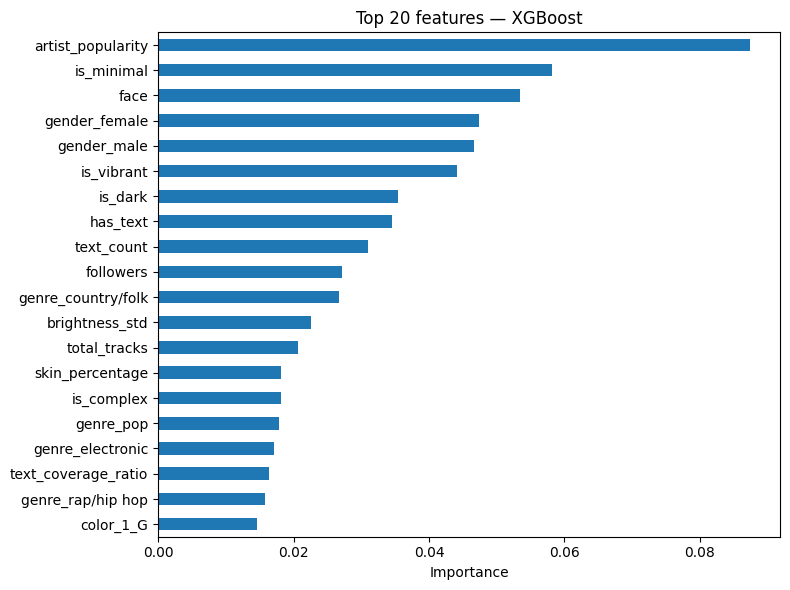

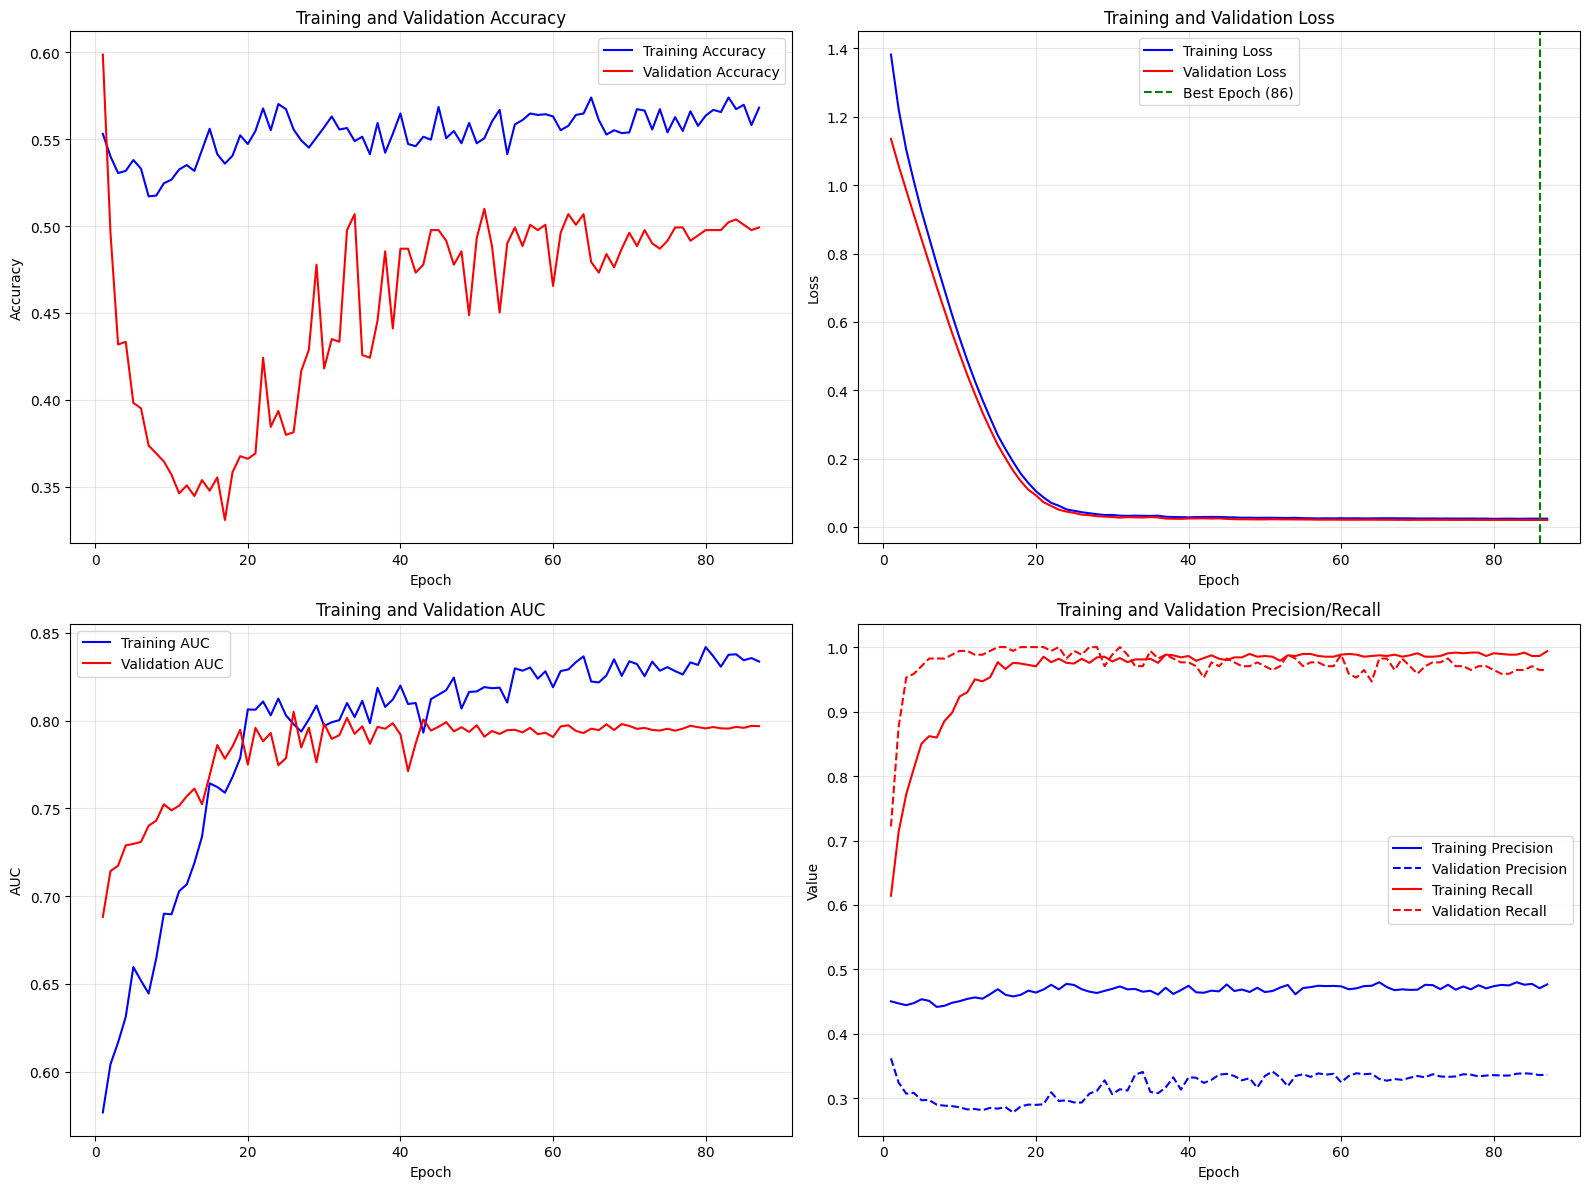

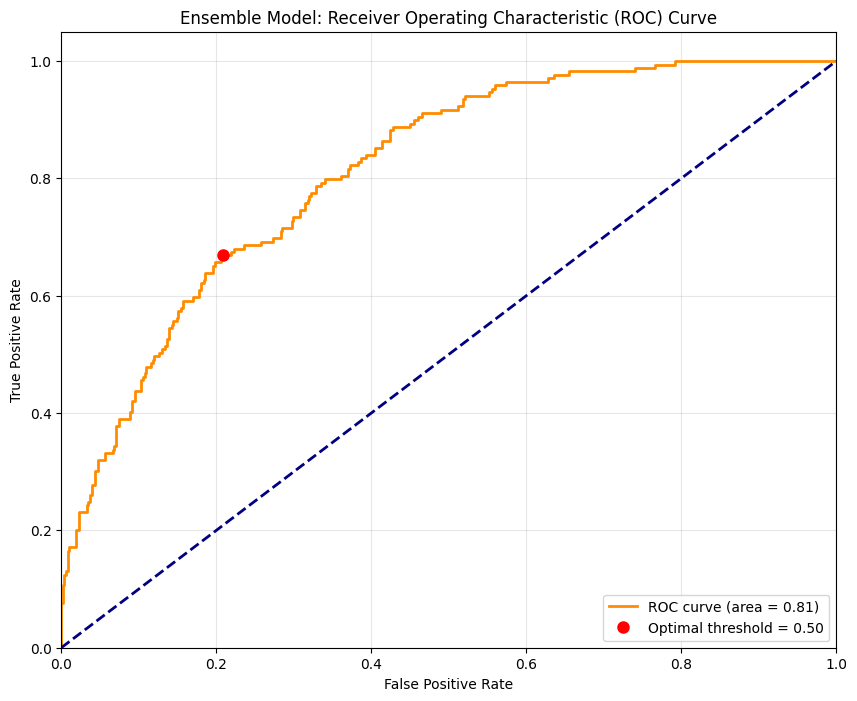

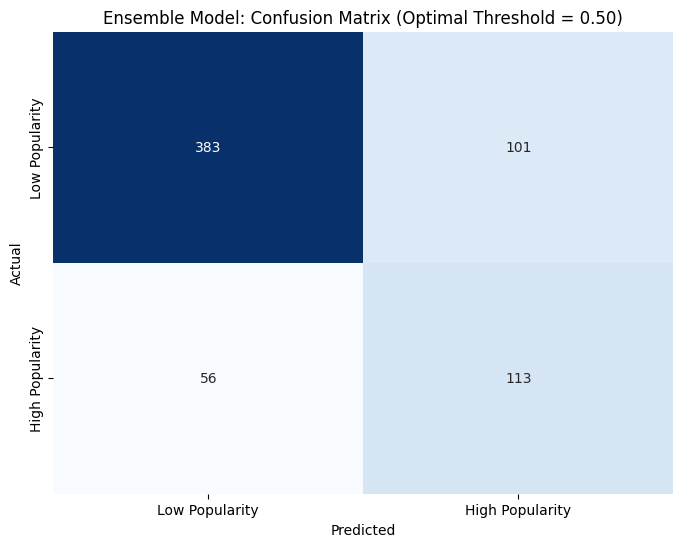


Ensemble Model - Optimal Threshold (0.5031):
- Accuracy: 0.7596
- Precision: 0.5280
- Recall: 0.6686
- F1 Score: 0.5901
- AUC: 0.8131

FINAL ENSEMBLE MODEL REPORT AND RECOMMENDATIONS

Class Imbalance Handling:
- Original class distribution: [2417  845] (25.9% positive class)
- SMOTE applied to generate synthetic minority samples
- After SMOTE training class distribution: [1449  941]
- ANN Loss function: Focal Loss (gamma=2, alpha=0.6)
- Ensemble optimal classification threshold: 0.5031

Ensemble Model Performance:
- Test AUC: 0.8131
- Test Accuracy: 0.7596
- Test Precision: 0.5280
- Test Recall: 0.6686
- Test F1 Score: 0.5901

Model Comparison (AUC):
- ANN Model: 0.8151
- XGBoost Model: 0.8045
- Ensemble Model: 0.8131


In [41]:
# target - top 25% popularity
y_targ = df.popularity.values
cutoff = 65
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")

# Calculate class weights based on the imbalance
n_samples = len(y_clf)
n_classes = len(np.unique(y_clf))
class_counts = np.bincount(y_clf)
class_weights = {i: (n_samples / (n_classes * count)) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {class_weights}")
X = df.drop(columns=['popularity']).values

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Positive class: {sum(y_train_clf)}/{len(y_train_clf)} ({sum(y_train_clf)/len(y_train_clf)*100:.1f}%)")
print(f"Validation set: {X_val.shape}, Positive class: {sum(y_val_clf)}/{len(y_val_clf)} ({sum(y_val_clf)/len(y_val_clf)*100:.1f}%)")
print(f"Test set: {X_test.shape}, Positive class: {sum(y_test_clf)}/{len(y_test_clf)} ({sum(y_test_clf)/len(y_test_clf)*100:.1f}%)")

# Apply SMOTE for imbalance
print("\n==== Applying SMOTE ====")
print(f"Before SMOTE - Training class distribution: {np.bincount(y_train_clf)}")
print(f"Before SMOTE - Training class ratio: 1:{np.bincount(y_train_clf)[0]/np.bincount(y_train_clf)[1]:.2f}")

smote = SMOTE(random_state=42, sampling_strategy=0.65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_clf)

# New class distribution
print(f"After SMOTE - Training class distribution: {np.bincount(y_train_smote)}")
print(f"After SMOTE - Training class ratio: 1:{np.bincount(y_train_smote)[0]/np.bincount(y_train_smote)[1]:.2f}")
print(f"Original training set shape: {X_train.shape}, New training set shape: {X_train_smote.shape}")

# Update training data
X_train = X_train_smote
y_train_clf = y_train_smote

# feature selection - random forest
print("\n==== Feature Selection ====")
print("Performing feature selection to reduce dimensionality...")

selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), threshold="median")

# Fit and transform the training data
selector.fit(X_train, y_train_clf)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Get selected feature indices and names
selected_features_idx = selector.get_support(indices=True)
feature_names = df.drop(columns=['popularity']).columns.tolist()
selected_feature_names = [feature_names[i] for i in selected_features_idx]

print(f"Selected {len(selected_feature_names)} out of {len(feature_names)} features")
print("Selected features:", selected_feature_names[:10], "..." if len(selected_feature_names) > 10 else "")
input_shape = X_train_selected.shape[1]
print(f"New input shape: {input_shape}")


# Build ANN Classification
clf_model = models.Sequential([
    # Input layer
    layers.Input(shape=(input_shape,)),

    # Gaussian Layer - adds noise during training for regularization
    layers.GaussianNoise(0.1),

    # First layer
    layers.Dense(112, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    #Second layer
    layers.Dense(64, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    # Output layer
    layers.Dense(1, activation='sigmoid')])

# Compile model
# focal loss to address class imbalance
def focal_loss(gamma=3, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, 1e-8, 1.0))) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, 1e-8, 1.0)))
    return focal_loss_fixed

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
clf_model.compile(
    optimizer=optimizer,
    # Use focal loss with alpha > 0.5 to give more importance to minority class
    loss=focal_loss(gamma=3, alpha=0.9),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()])

# callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased patience for SMOTE dataset
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Reduce learning rate when plateauing
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1)

# Custom callback to monitor for overfitting with SMOTE
class SMOTEOverfittingMonitor(callbacks.Callback):
    def __init__(self, threshold=0.2, patience=3):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.gap_history = []
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        acc_gap = logs.get('accuracy') - logs.get('val_accuracy')
        self.gap_history.append(acc_gap)

        print(f"\nEpoch {epoch+1}: Train-Val accuracy gap: {acc_gap:.4f}")

        # gap shouldn't be too large
        if acc_gap > self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping: Accuracy gap > {self.threshold:.2f} for {self.patience} epochs")
                self.model.stop_training = True
        else:
            self.wait = 0

# Add overfitting monitor
gap_monitor = SMOTEOverfittingMonitor(threshold=0.2, patience=3)

# Train model - with SMOTE we can use milder class weights
history = clf_model.fit(
    X_train_selected, y_train_clf,
    validation_data=(X_val_selected, y_val_clf),
    epochs=120,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, gap_monitor],
    class_weight={0: 1.0, 1: 1.7},
    verbose=1)

from itertools import product
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 1) Define a small grid of hyperparameters to try
param_grid = {
    "learning_rate":    [0.01, 0.05, 0.1],
    "max_depth":        [3, 4, 5],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

best_auc    = 0.0
best_params = {}

# 2) Loop over every combination
for lr, md, ss, cs in product(param_grid["learning_rate"],
                              param_grid["max_depth"],
                              param_grid["subsample"],
                              param_grid["colsample_bytree"]):
    model = XGBClassifier(
        n_estimators=200,            # keep this modest to speed up the grid
        learning_rate=lr,
        max_depth=md,
        subsample=ss,
        colsample_bytree=cs,
        random_state=42,
        eval_metric="auc"
    )
    # fit on your SMOTE+selected training data, watch the validation fold
    model.fit(
        X_train_selected, y_train_clf,
        eval_set=[(X_val_selected, y_val_clf)],
        verbose=False
    )
    # evaluate
    val_proba = model.predict_proba(X_val_selected)[:,1]
    auc = roc_auc_score(y_val_clf, val_proba)
    print(f"lr={lr}, depth={md}, subsample={ss}, colsample={cs} → AUC: {auc:.4f}")

    if auc > best_auc:
        best_auc    = auc
        best_params = {"learning_rate":lr, "max_depth":md,
                       "subsample":ss, "colsample_bytree":cs}

print(f"\n→ Best params: {best_params}, Validation AUC: {best_auc:.4f}")

# 3) Re‑train your final XGB with the chosen hyperparameters
xgb_model = XGBClassifier(
    n_estimators=500,
    **best_params,
    random_state=42,
    eval_metric="auc"
)
xgb_model.fit(
    X_train_selected, y_train_clf,
    eval_set=[(X_train_selected, y_train_clf), (X_val_selected, y_val_clf)],
    verbose=True
)

# Get predicted probabilities from both models
ann_val_proba  = clf_model.predict(X_val_selected).ravel()
xgb_val_proba  = xgb_model.predict_proba(X_val_selected)[:,1]

# Ensemble by simple average
ensemble_val_proba = (ann_val_proba + xgb_val_proba) / 2

print("\nValidation AUCs:")
print(f" ANN only : {roc_auc_score(y_val_clf, ann_val_proba):.4f}")
print(f" XGB only : {roc_auc_score(y_val_clf, xgb_val_proba):.4f}")
print(f" Ensemble : {roc_auc_score(y_val_clf, ensemble_val_proba):.4f}")

# Repeat on test set
ann_test_proba = clf_model.predict(X_test_selected).ravel()
xgb_test_proba = xgb_model.predict_proba(X_test_selected)[:,1]
ensemble_test_proba = (ann_test_proba + xgb_test_proba) / 2

print("\nTest AUCs:")
print(f" ANN only : {roc_auc_score(y_test_clf, ann_test_proba):.4f}")
print(f" XGB only : {roc_auc_score(y_test_clf, xgb_test_proba):.4f}")
print(f" Ensemble : {roc_auc_score(y_test_clf, ensemble_test_proba):.4f}")

# Other metrics at 0.5 threshold for the ensemble
y_ens_pred = (ensemble_test_proba >= 0.5).astype(int)
print("\nEnsemble Test metrics (th=0.5):")
print(f" Accuracy : {accuracy_score(y_test_clf, y_ens_pred):.4f}")
print(f" Precision: {precision_score(y_test_clf, y_ens_pred):.4f}")
print(f" Recall   : {recall_score(y_test_clf, y_ens_pred):.4f}")
print(f" F1 Score : {f1_score(y_test_clf, y_ens_pred):.4f}")

# Feature importances from XGBoost
import pandas as pd

fi = pd.Series(
    xgb_model.feature_importances_,
    index=selected_feature_names
).sort_values(ascending=False)

print("\nTop 20 XGBoost feature importances:")
print(fi.head(20).to_string())

# Optionally, plot them:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
fi.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 features — XGBoost")
plt.tight_layout()
plt.show()

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(16, 12))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    # Plot main metrics
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')

    # Calculate ideal stopping point based on validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Check which metric names are available
    auc_keys = [key for key in history.history.keys() if 'auc' in key.lower()]
    val_auc_keys = [key for key in history.history.keys() if 'val' in key.lower() and 'auc' in key.lower()]

    # Plot AUC
    plt.subplot(2, 2, 3)
    if auc_keys and val_auc_keys:
        plt.plot(epochs, history.history[auc_keys[0]], 'b-', label='Training AUC')
        plt.plot(epochs, history.history[val_auc_keys[0]], 'r-', label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.title('AUC metrics not available')
    plt.grid(True, alpha=0.3)

    # Plot Precision and Recall - check which metrics are available
    plt.subplot(2, 2, 4)
    precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and not 'val' in key.lower()]
    val_precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and 'val' in key.lower()]
    recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and not 'val' in key.lower()]
    val_recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and 'val' in key.lower()]

    if precision_keys and val_precision_keys:
        plt.plot(epochs, history.history[precision_keys[0]], 'b-', label='Training Precision')
        plt.plot(epochs, history.history[val_precision_keys[0]], 'b--', label='Validation Precision')
    if recall_keys and val_recall_keys:
        plt.plot(epochs, history.history[recall_keys[0]], 'r-', label='Training Recall')
        plt.plot(epochs, history.history[val_recall_keys[0]], 'r--', label='Validation Recall')
    plt.title('Training and Validation Precision/Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history_with_smote.png')
    plt.show()

    return best_epoch

best_epoch = plot_training_history(history)

# ROC curve for ensemble predictions
fpr, tpr, thresholds = roc_curve(y_test_clf, ensemble_test_proba)
roc_auc = sklearn_auc(fpr, tpr)

# Find the optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(optimal_point[0], optimal_point[1], 'ro', markersize=8,
         label=f'Optimal threshold = {optimal_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Recalculate predictions with optimal threshold using ensemble
y_pred_optimal = (ensemble_test_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_clf, y_pred_optimal)

# Plot optimal threshold confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Ensemble Model: Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_ensemble_confusion_matrix.png')
plt.show()

# Calculate metrics for optimal threshold using ensemble predictions
metrics_optimal = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_optimal),
    'Precision': precision_score(y_test_clf, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_optimal, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_optimal, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, ensemble_test_proba)
}

print(f"\nEnsemble Model - Optimal Threshold ({optimal_threshold:.4f}):")
for metric, value in metrics_optimal.items():
    print(f"- {metric}: {value:.4f}")

# Final summary and recommendations with ensemble results
print("\n" + "="*50)
print("FINAL ENSEMBLE MODEL REPORT AND RECOMMENDATIONS")
print("="*50)

print("\nClass Imbalance Handling:")
print(f"- Original class distribution: {np.bincount(y_clf)} ({np.bincount(y_clf)[1]/len(y_clf)*100:.1f}% positive class)")
print(f"- SMOTE applied to generate synthetic minority samples")
print(f"- After SMOTE training class distribution: {np.bincount(y_train_clf)}")
print(f"- ANN Loss function: Focal Loss (gamma=2, alpha=0.6)")
print(f"- Ensemble optimal classification threshold: {optimal_threshold:.4f}")

print("\nEnsemble Model Performance:")
print(f"- Test AUC: {metrics_optimal['AUC']:.4f}")
print(f"- Test Accuracy: {metrics_optimal['Accuracy']:.4f}")
print(f"- Test Precision: {metrics_optimal['Precision']:.4f}")
print(f"- Test Recall: {metrics_optimal['Recall']:.4f}")
print(f"- Test F1 Score: {metrics_optimal['F1 Score']:.4f}")

# Compare individual models versus ensemble
print("\nModel Comparison (AUC):")
print(f"- ANN Model: {roc_auc_score(y_test_clf, ann_test_proba):.4f}")
print(f"- XGBoost Model: {roc_auc_score(y_test_clf, xgb_test_proba):.4f}")
print(f"- Ensemble Model: {roc_auc_score(y_test_clf, ensemble_test_proba):.4f}")

WITHOUT ARTIST POPULARITY

In [48]:
 df = df.drop(columns=['artist_popularity'],axis=1)

Class distribution - Overall: [2417  845]
Class imbalance ratio: 1:2.86
Calculated class weights: {0: np.float64(0.6748034753827058), 1: np.float64(1.9301775147928995)}
Training set: (1956, 98), Positive class: 507/1956 (25.9%)
Validation set: (653, 98), Positive class: 169/653 (25.9%)
Test set: (653, 98), Positive class: 169/653 (25.9%)

==== Applying SMOTE ====
Before SMOTE - Training class distribution: [1449  507]
Before SMOTE - Training class ratio: 1:2.86
After SMOTE - Training class distribution: [1449  941]
After SMOTE - Training class ratio: 1:1.54
Original training set shape: (1956, 98), New training set shape: (2390, 98)

==== Feature Selection ====
Performing feature selection to reduce dimensionality...
Selected 49 out of 98 features
Selected features: ['total_tracks', 'face', 'skin_percentage', 'followers', 'count_person', 'max_confidence_person', 'total_object_count', 'avg_detection_confidence', 'avg_brightness', 'brightness_std'] ...
New input shape: 49
Epoch 1/120
75/7

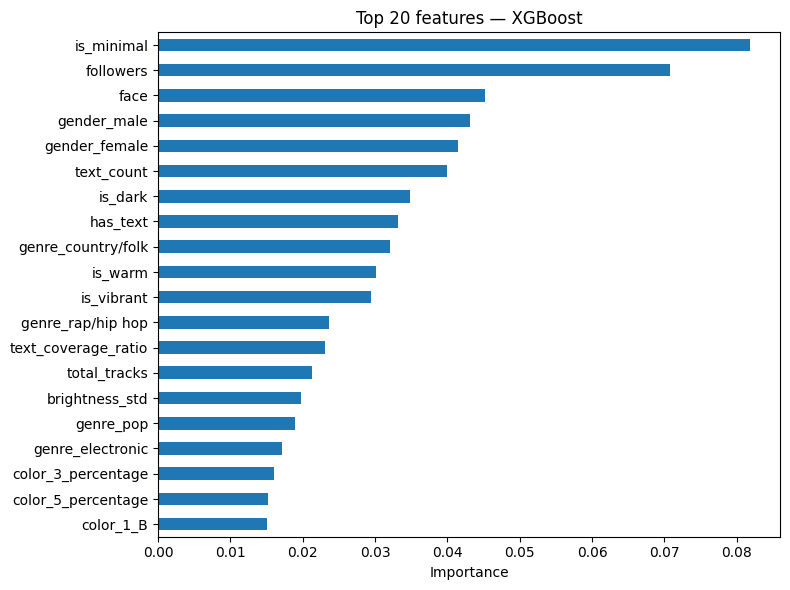

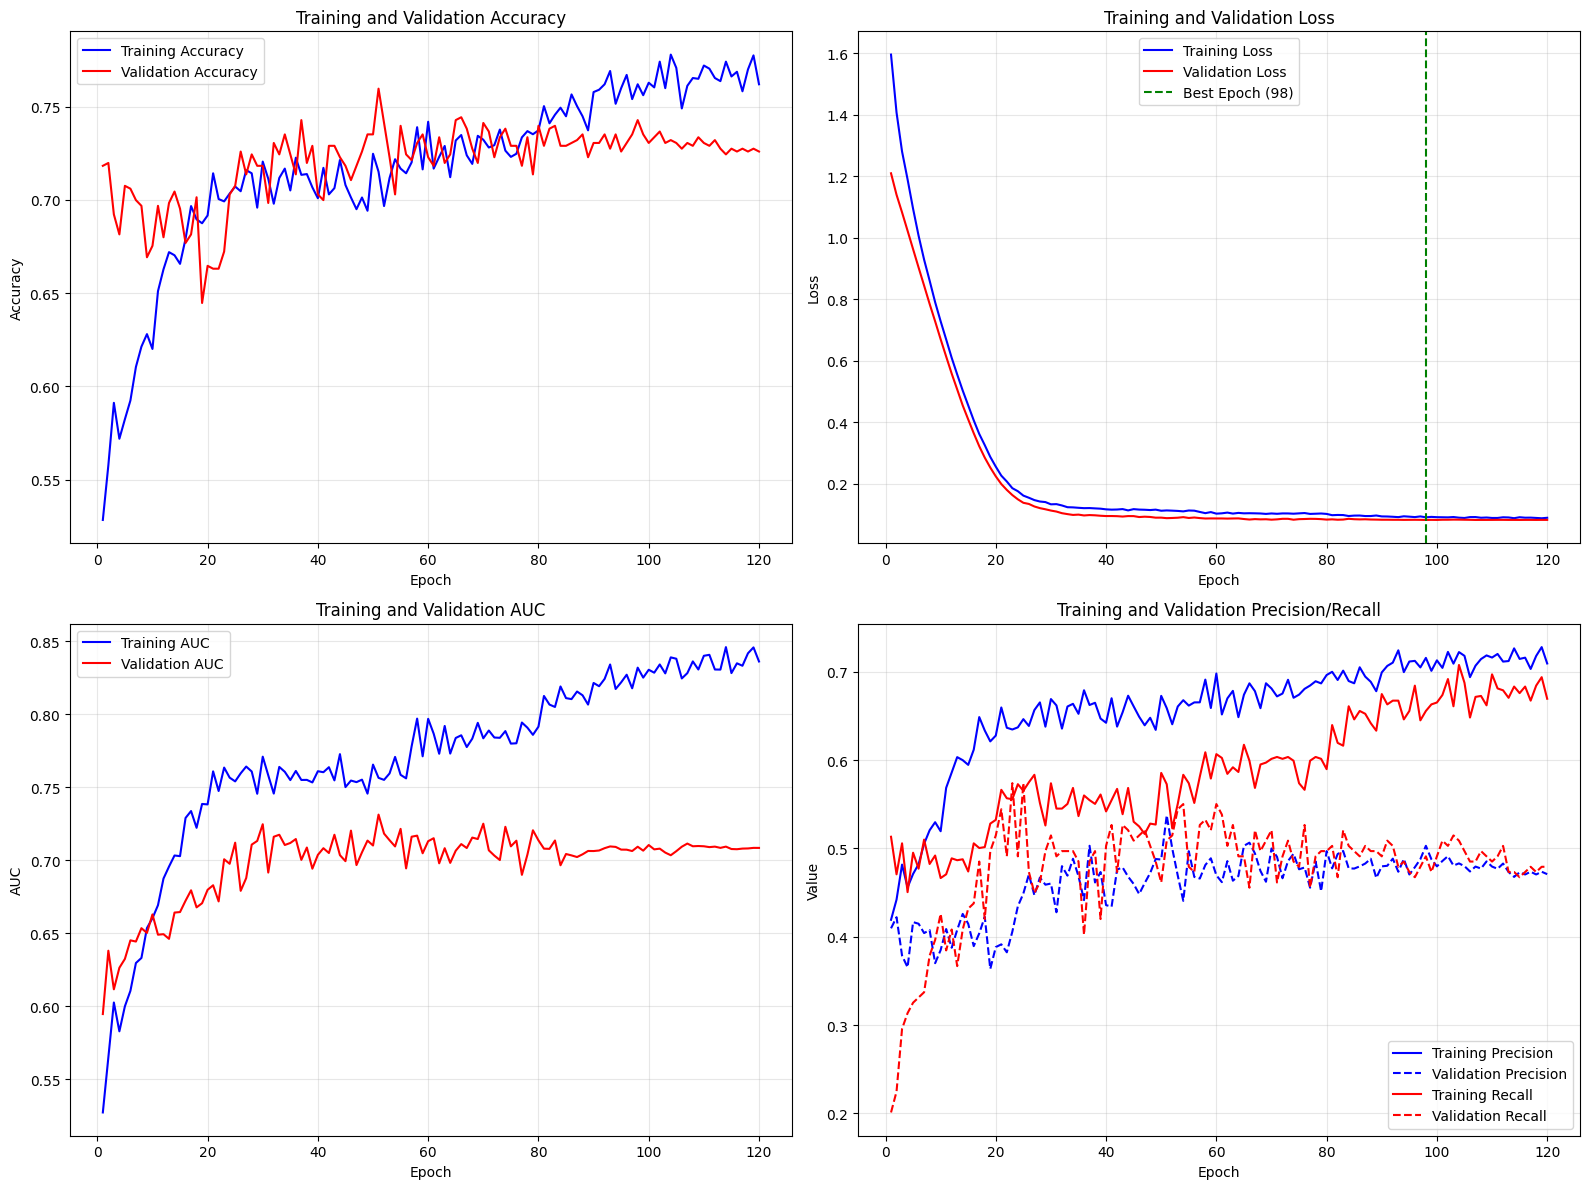

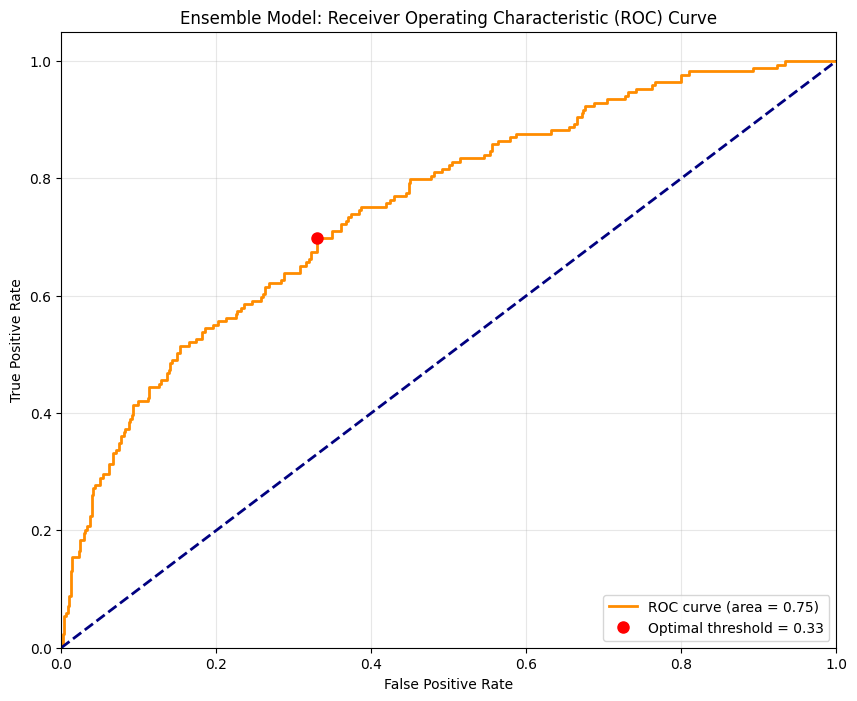

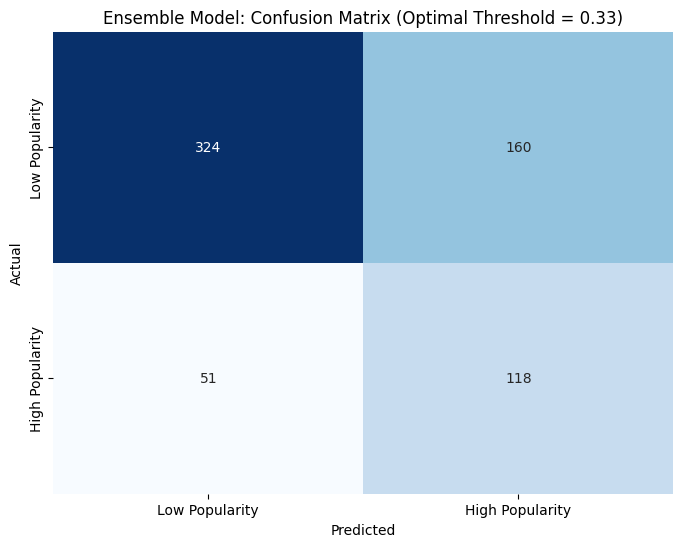


Ensemble Model - Optimal Threshold (0.3327):
- Accuracy: 0.6769
- Precision: 0.4245
- Recall: 0.6982
- F1 Score: 0.5280
- AUC: 0.7500

FINAL ENSEMBLE MODEL REPORT AND RECOMMENDATIONS

Class Imbalance Handling:
- Original class distribution: [2417  845] (25.9% positive class)
- SMOTE applied to generate synthetic minority samples
- After SMOTE training class distribution: [1449  941]
- ANN Loss function: Focal Loss (gamma=2, alpha=0.6)
- Ensemble optimal classification threshold: 0.3327

Ensemble Model Performance:
- Test AUC: 0.7500
- Test Accuracy: 0.6769
- Test Precision: 0.4245
- Test Recall: 0.6982
- Test F1 Score: 0.5280

Model Comparison (AUC):
- ANN Model: 0.7440
- XGBoost Model: 0.7383
- Ensemble Model: 0.7500


In [50]:
# target - top 25% popularity
y_targ = df.popularity.values
cutoff = 65
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")

# Calculate class weights based on the imbalance
n_samples = len(y_clf)
n_classes = len(np.unique(y_clf))
class_counts = np.bincount(y_clf)
class_weights = {i: (n_samples / (n_classes * count)) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {class_weights}")
X = df.drop(columns=['popularity']).values

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Positive class: {sum(y_train_clf)}/{len(y_train_clf)} ({sum(y_train_clf)/len(y_train_clf)*100:.1f}%)")
print(f"Validation set: {X_val.shape}, Positive class: {sum(y_val_clf)}/{len(y_val_clf)} ({sum(y_val_clf)/len(y_val_clf)*100:.1f}%)")
print(f"Test set: {X_test.shape}, Positive class: {sum(y_test_clf)}/{len(y_test_clf)} ({sum(y_test_clf)/len(y_test_clf)*100:.1f}%)")

# Apply SMOTE for imbalance
print("\n==== Applying SMOTE ====")
print(f"Before SMOTE - Training class distribution: {np.bincount(y_train_clf)}")
print(f"Before SMOTE - Training class ratio: 1:{np.bincount(y_train_clf)[0]/np.bincount(y_train_clf)[1]:.2f}")

smote = SMOTE(random_state=42, sampling_strategy=0.65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_clf)

# New class distribution
print(f"After SMOTE - Training class distribution: {np.bincount(y_train_smote)}")
print(f"After SMOTE - Training class ratio: 1:{np.bincount(y_train_smote)[0]/np.bincount(y_train_smote)[1]:.2f}")
print(f"Original training set shape: {X_train.shape}, New training set shape: {X_train_smote.shape}")

# Update training data
X_train = X_train_smote
y_train_clf = y_train_smote

# feature selection - random forest
print("\n==== Feature Selection ====")
print("Performing feature selection to reduce dimensionality...")

selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), threshold="median")

# Fit and transform the training data
selector.fit(X_train, y_train_clf)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Get selected feature indices and names
selected_features_idx = selector.get_support(indices=True)
feature_names = df.drop(columns=['popularity']).columns.tolist()
selected_feature_names = [feature_names[i] for i in selected_features_idx]

print(f"Selected {len(selected_feature_names)} out of {len(feature_names)} features")
print("Selected features:", selected_feature_names[:10], "..." if len(selected_feature_names) > 10 else "")
input_shape = X_train_selected.shape[1]
print(f"New input shape: {input_shape}")


# Build ANN Classification
clf_model = models.Sequential([
    # Input layer
    layers.Input(shape=(input_shape,)),

    # Gaussian Layer - adds noise during training for regularization
    layers.GaussianNoise(0.1),

    # First layer
    layers.Dense(112, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    #Second layer
    layers.Dense(64, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    # Output layer
    layers.Dense(1, activation='sigmoid')])

# Compile model
# focal loss to address class imbalance
def focal_loss(gamma=3, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, 1e-8, 1.0))) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, 1e-8, 1.0)))
    return focal_loss_fixed

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
clf_model.compile(
    optimizer=optimizer,
    # Use focal loss with alpha > 0.5 to give more importance to minority class
    loss=focal_loss(gamma=2, alpha=0.5),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()])

# callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased patience for SMOTE dataset
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Reduce learning rate when plateauing
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1)

# Custom callback to monitor for overfitting with SMOTE
class SMOTEOverfittingMonitor(callbacks.Callback):
    def __init__(self, threshold=0.2, patience=3):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.gap_history = []
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        acc_gap = logs.get('accuracy') - logs.get('val_accuracy')
        self.gap_history.append(acc_gap)

        print(f"\nEpoch {epoch+1}: Train-Val accuracy gap: {acc_gap:.4f}")

        # gap shouldn't be too large
        if acc_gap > self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping: Accuracy gap > {self.threshold:.2f} for {self.patience} epochs")
                self.model.stop_training = True
        else:
            self.wait = 0

# Add overfitting monitor
gap_monitor = SMOTEOverfittingMonitor(threshold=0.2, patience=3)

# Train model - with SMOTE we can use milder class weights
history = clf_model.fit(
    X_train_selected, y_train_clf,
    validation_data=(X_val_selected, y_val_clf),
    epochs=120,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, gap_monitor],
    class_weight={0: 1.0, 1: 1.7},
    verbose=1)

from itertools import product
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 1) Define a small grid of hyperparameters to try
param_grid = {
    "learning_rate":    [0.01, 0.05, 0.1],
    "max_depth":        [3, 4, 5],
    "subsample":        [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

best_auc    = 0.0
best_params = {}

# 2) Loop over every combination
for lr, md, ss, cs in product(param_grid["learning_rate"],
                              param_grid["max_depth"],
                              param_grid["subsample"],
                              param_grid["colsample_bytree"]):
    model = XGBClassifier(
        n_estimators=200,            # keep this modest to speed up the grid
        learning_rate=lr,
        max_depth=md,
        subsample=ss,
        colsample_bytree=cs,
        random_state=42,
        eval_metric="auc"
    )
    # fit on your SMOTE+selected training data, watch the validation fold
    model.fit(
        X_train_selected, y_train_clf,
        eval_set=[(X_val_selected, y_val_clf)],
        verbose=False
    )
    # evaluate
    val_proba = model.predict_proba(X_val_selected)[:,1]
    auc = roc_auc_score(y_val_clf, val_proba)
    print(f"lr={lr}, depth={md}, subsample={ss}, colsample={cs} → AUC: {auc:.4f}")

    if auc > best_auc:
        best_auc    = auc
        best_params = {"learning_rate":lr, "max_depth":md,
                       "subsample":ss, "colsample_bytree":cs}

print(f"\n→ Best params: {best_params}, Validation AUC: {best_auc:.4f}")

# 3) Re‑train your final XGB with the chosen hyperparameters
xgb_model = XGBClassifier(
    n_estimators=500,
    **best_params,
    random_state=42,
    eval_metric="auc"
)
xgb_model.fit(
    X_train_selected, y_train_clf,
    eval_set=[(X_train_selected, y_train_clf), (X_val_selected, y_val_clf)],
    verbose=True
)

# Get predicted probabilities from both models
ann_val_proba  = clf_model.predict(X_val_selected).ravel()
xgb_val_proba  = xgb_model.predict_proba(X_val_selected)[:,1]

# Ensemble by simple average
ensemble_val_proba = (ann_val_proba + xgb_val_proba) / 2

print("\nValidation AUCs:")
print(f" ANN only : {roc_auc_score(y_val_clf, ann_val_proba):.4f}")
print(f" XGB only : {roc_auc_score(y_val_clf, xgb_val_proba):.4f}")
print(f" Ensemble : {roc_auc_score(y_val_clf, ensemble_val_proba):.4f}")

# Repeat on test set
ann_test_proba = clf_model.predict(X_test_selected).ravel()
xgb_test_proba = xgb_model.predict_proba(X_test_selected)[:,1]
ensemble_test_proba = (ann_test_proba + xgb_test_proba) / 2

print("\nTest AUCs:")
print(f" ANN only : {roc_auc_score(y_test_clf, ann_test_proba):.4f}")
print(f" XGB only : {roc_auc_score(y_test_clf, xgb_test_proba):.4f}")
print(f" Ensemble : {roc_auc_score(y_test_clf, ensemble_test_proba):.4f}")

# Other metrics at 0.5 threshold for the ensemble
y_ens_pred = (ensemble_test_proba >= 0.5).astype(int)
print("\nEnsemble Test metrics (th=0.5):")
print(f" Accuracy : {accuracy_score(y_test_clf, y_ens_pred):.4f}")
print(f" Precision: {precision_score(y_test_clf, y_ens_pred):.4f}")
print(f" Recall   : {recall_score(y_test_clf, y_ens_pred):.4f}")
print(f" F1 Score : {f1_score(y_test_clf, y_ens_pred):.4f}")

# Feature importances from XGBoost
import pandas as pd

fi = pd.Series(
    xgb_model.feature_importances_,
    index=selected_feature_names
).sort_values(ascending=False)

print("\nTop 20 XGBoost feature importances:")
print(fi.head(20).to_string())

# Optionally, plot them:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
fi.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 features — XGBoost")
plt.tight_layout()
plt.show()

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(16, 12))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    # Plot main metrics
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')

    # Calculate ideal stopping point based on validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Check which metric names are available
    auc_keys = [key for key in history.history.keys() if 'auc' in key.lower()]
    val_auc_keys = [key for key in history.history.keys() if 'val' in key.lower() and 'auc' in key.lower()]

    # Plot AUC
    plt.subplot(2, 2, 3)
    if auc_keys and val_auc_keys:
        plt.plot(epochs, history.history[auc_keys[0]], 'b-', label='Training AUC')
        plt.plot(epochs, history.history[val_auc_keys[0]], 'r-', label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.title('AUC metrics not available')
    plt.grid(True, alpha=0.3)

    # Plot Precision and Recall - check which metrics are available
    plt.subplot(2, 2, 4)
    precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and not 'val' in key.lower()]
    val_precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and 'val' in key.lower()]
    recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and not 'val' in key.lower()]
    val_recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and 'val' in key.lower()]

    if precision_keys and val_precision_keys:
        plt.plot(epochs, history.history[precision_keys[0]], 'b-', label='Training Precision')
        plt.plot(epochs, history.history[val_precision_keys[0]], 'b--', label='Validation Precision')
    if recall_keys and val_recall_keys:
        plt.plot(epochs, history.history[recall_keys[0]], 'r-', label='Training Recall')
        plt.plot(epochs, history.history[val_recall_keys[0]], 'r--', label='Validation Recall')
    plt.title('Training and Validation Precision/Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history_with_smote.png')
    plt.show()

    return best_epoch

best_epoch = plot_training_history(history)

# ROC curve for ensemble predictions
fpr, tpr, thresholds = roc_curve(y_test_clf, ensemble_test_proba)
roc_auc = sklearn_auc(fpr, tpr)

# Find the optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(optimal_point[0], optimal_point[1], 'ro', markersize=8,
         label=f'Optimal threshold = {optimal_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Recalculate predictions with optimal threshold using ensemble
y_pred_optimal = (ensemble_test_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_clf, y_pred_optimal)

# Plot optimal threshold confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Ensemble Model: Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_ensemble_confusion_matrix.png')
plt.show()

# Calculate metrics for optimal threshold using ensemble predictions
metrics_optimal = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_optimal),
    'Precision': precision_score(y_test_clf, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_optimal, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_optimal, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, ensemble_test_proba)
}

print(f"\nEnsemble Model - Optimal Threshold ({optimal_threshold:.4f}):")
for metric, value in metrics_optimal.items():
    print(f"- {metric}: {value:.4f}")

# Final summary and recommendations with ensemble results
print("\n" + "="*50)
print("FINAL ENSEMBLE MODEL REPORT AND RECOMMENDATIONS")
print("="*50)

print("\nClass Imbalance Handling:")
print(f"- Original class distribution: {np.bincount(y_clf)} ({np.bincount(y_clf)[1]/len(y_clf)*100:.1f}% positive class)")
print(f"- SMOTE applied to generate synthetic minority samples")
print(f"- After SMOTE training class distribution: {np.bincount(y_train_clf)}")
print(f"- ANN Loss function: Focal Loss (gamma=2, alpha=0.6)")
print(f"- Ensemble optimal classification threshold: {optimal_threshold:.4f}")

print("\nEnsemble Model Performance:")
print(f"- Test AUC: {metrics_optimal['AUC']:.4f}")
print(f"- Test Accuracy: {metrics_optimal['Accuracy']:.4f}")
print(f"- Test Precision: {metrics_optimal['Precision']:.4f}")
print(f"- Test Recall: {metrics_optimal['Recall']:.4f}")
print(f"- Test F1 Score: {metrics_optimal['F1 Score']:.4f}")

# Compare individual models versus ensemble
print("\nModel Comparison (AUC):")
print(f"- ANN Model: {roc_auc_score(y_test_clf, ann_test_proba):.4f}")
print(f"- XGBoost Model: {roc_auc_score(y_test_clf, xgb_test_proba):.4f}")
print(f"- Ensemble Model: {roc_auc_score(y_test_clf, ensemble_test_proba):.4f}")